# aPMV (Adaptive Predicted Mean Vote) Setpoints Demonstration

This notebook demonstrates how to use the `apmv_setpoints` module from the `accim` package to integrate Adaptive Predicted Mean Vote (aPMV) setpoints into an EnergyPlus model. The entire workflow, including model modification and simulation, is managed using Python.

## Prerequisites

Before running this notebook, ensure the following files are in the same directory:
- `aPMV_testing_v01_no_script.idf`: The base EnergyPlus model.
- `Seville.epw`: The weather file for the simulation.

## Workflow Overview

The demonstration is divided into three main parts:
1.  **Baseline Simulation:** We first run the model with standard PMV setpoints (equivalent to aPMV with an adaptive coefficient, λ, of 0). This establishes a reference case.
2.  **Adaptive Simulation:** We then apply zone-specific `λ` coefficients to enable aPMV-based control and compare the results.
3.  **Cleanup:** Finally, we remove the simulation output directories.

## Initial Setup and Model Loading

First, we import the necessary libraries, including `pandas` and `seaborn` for data handling and visualization, and modules from `besos` and `accim` for EnergyPlus interaction.

The code below then loads the IDF file into a `besos` building object. For this demonstration, we modify the occupancy schedules to ensure the zones are always occupied, which makes the comfort control logic continuously active and easier to visualize. Finally, we identify the occupied thermal zones that will be controlled.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from besos import eppy_funcs as ef
from besos import eplus_funcs as ep
import accim.sim.apmv_setpoints as apmv
import os

# Visualization setup
plt.rcParams['figure.figsize'] = [15, 6]
sns.set_style("whitegrid")

# Define file paths
idfname = 'TestModel_onlyGeometryForVRFsystem_2zones_CalcVent_V940.idf'
epwfile = "Seville.epw"

print(f"IDF File: {idfname}")
print(f"EPW File: {epwfile}")

IDF File: TestModel_onlyGeometryForVRFsystem_2zones_CalcVent_V940.idf
EPW File: Seville.epw


In [2]:
# Load the building model using BESOS
building = ef.get_building(idfname)

# Ensure zones are always occupied for the demonstration
apmv.set_zones_always_occupied(building=building)

zones = [i.Zone_or_ZoneList_Name for i in building.idfobjects['people']]
print("Building loaded successfully.")
print(f"Occupied zones found: {zones}")

On Schedule already was in the model
Building loaded successfully.
Occupied zones found: ['Block1:Zone2', 'Block1:Zone1']


In [3]:
# Helper function to find columns dynamically (used in both parts)
def get_columns(df, zone_name_part):
    # Find aPMV value column
    apmv_col = [i for i in df.columns if 'EMS:aPMV' in i and zone_name_part in i and 'Setpoint' not in i][0]
    # Find cooling setpoint column (no tolerance)
    cool_sp_col = [i for i in df.columns if 'EMS:aPMV Cooling Setpoint No Tolerance' in i and zone_name_part in i][0]
    # Find heating setpoint column (no tolerance)
    heat_sp_col = [i for i in df.columns if 'EMS:aPMV Heating Setpoint No Tolerance' in i and zone_name_part in i][0]
    
    return apmv_col, cool_sp_col, heat_sp_col

## Part 1: Baseline Scenario (Standard PMV)

First, we will run a baseline simulation using standard Fanger PMV control. This is achieved by setting the adaptive coefficients (λ) to **0**.

According to the aPMV equation:
$$ aPMV = \frac{PMV}{1 + \lambda \times PMV} $$

If λ = 0, then **aPMV = PMV**. This allows us to simulate standard PMV control with fixed setpoints at ±0.5, which will serve as our reference case.

In [4]:
# Create a copy of the building for the baseline simulation
building_pmv = ef.get_building(idfname)
apmv.add_vrf_system(building=building_pmv)
apmv.set_zones_always_occupied(building=building_pmv)

building_pmv.saveas('TestModel_V940_VRFsystem_notebook.idf')



Searching Spacelist objects returned KeyError. That means these are not supported in the EnergyPlus version 9-4-0
The occupied zones in the model <besos.IDF_class.IDF object at 0x000001ACAF5A13D0> are:
BLOCK1:ZONE2
BLOCK1:ZONE1
The zones in the model <besos.IDF_class.IDF object at 0x000001ACAF5A13D0> are:
BLOCK1_ZONE2
BLOCK1_ZONE1
The people objects in the model have been amended.
Cooling Fanger comfort setpoint: Always 0.5 Schedule has been added
Heating Fanger comfort setpoint: Always -0.5 Schedule has been added
BLOCK1:ZONE2 Comfort Control ZoneControl:Thermostat:ThermalComfort has been added
BLOCK1:ZONE2 Dual Comfort Setpoint ThermostatSetpoint:ThermalComfort:Fanger:DualSetpoint has been added
BLOCK1:ZONE1 Comfort Control ZoneControl:Thermostat:ThermalComfort has been added
BLOCK1:ZONE1 Dual Comfort Setpoint ThermostatSetpoint:ThermalComfort:Fanger:DualSetpoint has been added
On Schedule already was in the model
TypOperativeTempControlSch Schedule already was in the model
All ZoneH

In [5]:
[i for i in building_pmv.idfobjects['ZoneControl:Thermostat']]

[
 ZONECONTROL:THERMOSTAT,
     BLOCK1:ZONE2 Thermostat,    !- Name
     BLOCK1:ZONE2,             !- Zone or ZoneList Name
     Control type schedule: Always 4,    !- Control Type Schedule Name
     ThermostatSetpoint:DualSetpoint,    !- Control 1 Object Type
     BLOCK1:ZONE2 Dual SP,     !- Control 1 Name
     ,                         !- Control 2 Object Type
     ,                         !- Control 2 Name
     ,                         !- Control 3 Object Type
     ,                         !- Control 3 Name
     ,                         !- Control 4 Object Type
     ,                         !- Control 4 Name
     0;                        !- Temperature Difference Between Cutout And Setpoint,
 
 ZONECONTROL:THERMOSTAT,
     BLOCK1:ZONE1 Thermostat,    !- Name
     BLOCK1:ZONE1,             !- Zone or ZoneList Name
     Control type schedule: Always 4,    !- Control Type Schedule Name
     ThermostatSetpoint:DualSetpoint,    !- Control 1 Object Type
     BLOCK1:ZONE1 Dual SP,  

In [6]:

[i for i in building.idfobjects['ZoneControl:Thermostat']]


[]

Next step will be calling the `apply_apmv_setpoints` function, therefore, the documentation should be read before, or at least, the available parameters should be checked:

*   **`building`**: The `besos.IDF_class` building object to be modified.
*   **`outputs_freq`**: List of frequencies for simulation outputs (e.g., `['hourly']`).
*   **`other_PMV_related_outputs`**: If `True`, adds detailed PMV calculation outputs for analysis.
*   **`adap_coeff_cooling`**: Adaptive coefficient (λ) for the cooling season (default: `0.293`).
*   **`adap_coeff_heating`**: Adaptive coefficient (λ) for the heating season (default: `-0.293`).
*   **`pmv_cooling_sp`**: Upper base PMV limit for cooling (default: `0.5`).
*   **`pmv_heating_sp`**: Lower base PMV limit for heating (default: `-0.5`).
*   **`tolerance_cooling_sp_cooling_season`**: Negative offset for the cooling setpoint during the cooling season (default: `-0.1`).
*   **`tolerance_cooling_sp_heating_season`**: Negative offset for the cooling setpoint during the heating season (default: `-0.1`).
*   **`tolerance_heating_sp_cooling_season`**: Positive offset for the heating setpoint during the cooling season (default: `0.1`).
*   **`tolerance_heating_sp_heating_season`**: Positive offset for the heating setpoint during the heating season (default: `0.1`).
*   **`cooling_season_start`**: Global start of the cooling season (day of year or "dd/mm") (default: `120`).
*   **`cooling_season_end`**: Global end of the cooling season (day of year or "dd/mm") (default: `210`).

The full documentation can be read below:

### Applying PMV Setpoints (λ = 0)

Now, we call the core function of the module: `apply_apmv_setpoints`. By setting `adap_coeff_cooling` and `adap_coeff_heating` to `0`, we are instructing `accim` to implement standard PMV control. The function modifies the `building_pmv` object in-memory by adding all the necessary EnergyPlus objects (Schedules, EMS Sensors, Actuators, Programs, and Output Variables) required for the control logic.

The `verboseMode=True` argument prints a log of every object being added to the IDF model.

In [7]:
# Apply setpoints with coefficients set to 0
building_with_pmv = apmv.apply_apmv_setpoints(
    building=building_pmv,
    adap_coeff_cooling=0,
    adap_coeff_heating=0,
    pmv_cooling_sp=0.5,
    pmv_heating_sp=-0.5,
    cooling_season_start='01/04',  # April 1st
    cooling_season_end='01/10',    # October 1st
    verboseMode=True,
    tolerance_cooling_sp_cooling_season=-0.15,
    tolerance_cooling_sp_heating_season=-0.15
)

PMV_H_SP_Block1_Zone2 Schedule has been added
PMV_H_SP_Block1_Zone1 Schedule has been added
PMV_C_SP_Block1_Zone2 Schedule has been added
PMV_C_SP_Block1_Zone1 Schedule has been added
Added - PMV_Block1_Zone2 Sensor
Added - People_Occupant_Count_Block1_Zone2 Sensor
Added - PMV_Block1_Zone1 Sensor
Added - People_Occupant_Count_Block1_Zone1 Sensor
Added - PMV_H_SP_act_Block1_Zone2 Actuator
Added - PMV_H_SP_act_Block1_Zone1 Actuator
Added - PMV_C_SP_act_Block1_Zone2 Actuator
Added - PMV_C_SP_act_Block1_Zone1 Actuator
Added - CoolingSeason GlobalVariable object
Added - CoolSeasonEnd GlobalVariable object
Added - CoolSeasonStart GlobalVariable object
Added - tolerance_cooling_sp_Block1_Zone2 GlobalVariable object
Added - tolerance_cooling_sp_Block1_Zone1 GlobalVariable object
Added - tolerance_cooling_sp_cooling_season_Block1_Zone2 GlobalVariable object
Added - tolerance_cooling_sp_cooling_season_Block1_Zone1 GlobalVariable object
Added - tolerance_cooling_sp_heating_season_Block1_Zone2 Glo

In [8]:
[i for i in building_pmv.idfobjects['ZoneControl:Thermostat']]

[
 ZONECONTROL:THERMOSTAT,
     BLOCK1:ZONE2 Thermostat,    !- Name
     BLOCK1:ZONE2,             !- Zone or ZoneList Name
     Control type schedule: Always 4,    !- Control Type Schedule Name
     ThermostatSetpoint:DualSetpoint,    !- Control 1 Object Type
     BLOCK1:ZONE2 Dual SP,     !- Control 1 Name
     ,                         !- Control 2 Object Type
     ,                         !- Control 2 Name
     ,                         !- Control 3 Object Type
     ,                         !- Control 3 Name
     ,                         !- Control 4 Object Type
     ,                         !- Control 4 Name
     0;                        !- Temperature Difference Between Cutout And Setpoint,
 
 ZONECONTROL:THERMOSTAT,
     BLOCK1:ZONE1 Thermostat,    !- Name
     BLOCK1:ZONE1,             !- Zone or ZoneList Name
     Control type schedule: Always 4,    !- Control Type Schedule Name
     ThermostatSetpoint:DualSetpoint,    !- Control 1 Object Type
     BLOCK1:ZONE1 Dual SP,  

### Running the Baseline Simulation

With the IDF file now modified by `accim`, we use BESOS's `run_building` function to execute the EnergyPlus simulation. The results will be saved in the `sim_results_pmv` directory.

In [9]:
# Run simulation
output_dir_base = 'sim_results_pmv'
print(f"Running baseline simulation in: {output_dir_base}...")

ep.run_building(
    building=building_with_pmv,
    out_dir=output_dir_base,
    epw=epwfile
)
print("Baseline simulation finished.")

Running baseline simulation in: sim_results_pmv...
Running EnergyPlus with stdout output suppressed...
Baseline simulation finished.


### Visualizing the Baseline Results

We load the simulation results from the output CSV file and plot the PMV for Zone 1. As expected, the plot shows the zone's PMV value fluctuating between the fixed heating and cooling setpoints of -0.5 and +0.5, respectively. This confirms our baseline is working correctly.

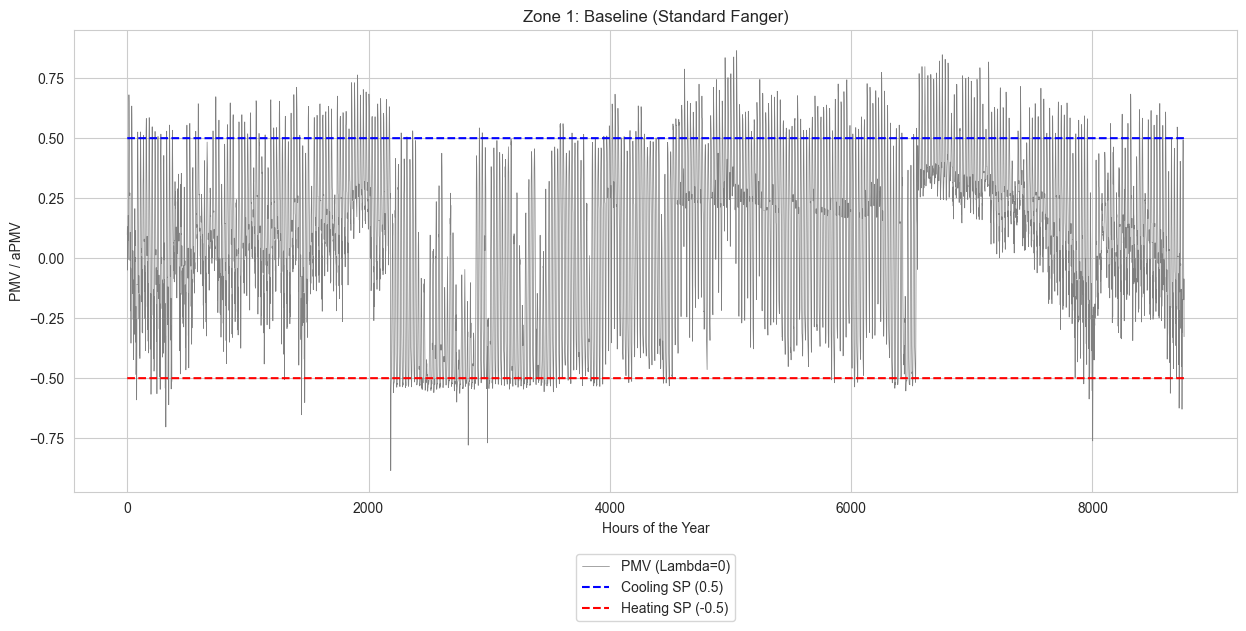

In [10]:
# Load Baseline results
results_path_base = os.path.join(output_dir_base, 'eplusout.csv')
df_base = pd.read_csv(results_path_base)
df_base['Hour'] = df_base.index

# Get columns for Zone 1
z1_apmv_b, z1_cool_b, z1_heat_b = get_columns(df_base, 'Block1_Zone1')

# Visualize Baseline
plt.figure()
sns.lineplot(data=df_base, x='Hour', y=z1_apmv_b, color='gray', linewidth=0.5, label='PMV (Lambda=0)')
sns.lineplot(data=df_base, x='Hour', y=z1_cool_b, color='blue', linestyle='--', label='Cooling SP (0.5)')
sns.lineplot(data=df_base, x='Hour', y=z1_heat_b, color='red', linestyle='--', label='Heating SP (-0.5)')

plt.title('Zone 1: Baseline (Standard Fanger)')
plt.ylabel('PMV / aPMV')
plt.xlabel('Hours of the Year')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), frameon=True)
plt.show()

## Part 2: Adaptive Scenario (aPMV)

Now, we will apply true aPMV logic by defining distinct adaptive coefficients (λ) for each zone. This demonstrates the tool's ability to handle multi-zone buildings with different occupant adaptation profiles. For this example:

*   **Block1:Zone1:** Will be assigned a **high adaptation** profile (Cooling λ = 0.3, Heating λ = 0.1).
*   **Block1:Zone2:** Will be assigned a **low adaptation** profile (Cooling λ = 0.2, Heating λ = 0.05).

### Defining Zone-Specific Adaptive Coefficients

A key feature of the `apmv_setpoints` module is its ability to accept dictionaries for most parameters. This allows us to assign unique values to each thermal zone. Here, we create separate dictionaries for the heating and cooling adaptive coefficients.

In [11]:
# Define dictionaries for specific coefficients per zone
adap_coeff_cooling = {}
adap_coeff_heating = {}

for zone in zones:
    if 'zone1' in zone.lower():
        adap_coeff_cooling.update({zone: 0.3})
        adap_coeff_heating.update({zone: 0.1})
        print(f"Configuring {zone}: Cooling Coeff=0.3, Heating Coeff=0.1")

    if 'zone2' in zone.lower():
        adap_coeff_cooling.update({zone: 0.2})
        adap_coeff_heating.update({zone: 0.05})
        print(f"Configuring {zone}: Cooling Coeff=0.2, Heating Coeff=0.05")

Configuring Block1:Zone2: Cooling Coeff=0.2, Heating Coeff=0.05
Configuring Block1:Zone1: Cooling Coeff=0.3, Heating Coeff=0.1


In [12]:
adap_coeff_cooling

{'Block1:Zone2': 0.2, 'Block1:Zone1': 0.3}

In [13]:
adap_coeff_heating

{'Block1:Zone2': 0.05, 'Block1:Zone1': 0.1}

In [14]:
# Generate DataFrame to inspect arguments before applying (Optional)
df_args = apmv.generate_df_from_args(
    building=building,
    adap_coeff_cooling=adap_coeff_cooling,
    adap_coeff_heating=adap_coeff_heating,
    pmv_cooling_sp=0.5,
    pmv_heating_sp=-0.5,
)
display(df_args)

,adap_coeff_cooling,adap_coeff_heating,pmv_cooling_sp,pmv_heating_sp,tolerance_cooling_sp_cooling_season,tolerance_cooling_sp_heating_season,tolerance_heating_sp_cooling_season,tolerance_heating_sp_heating_season,underscore_zonename
Block1:Zone2,0.2,0.05,0.5,-0.5,-0.1,-0.1,0.1,0.1,Block1_Zone2
Block1:Zone1,0.3,0.10,0.5,-0.5,-0.1,-0.1,0.1,0.1,Block1_Zone1


### Applying aPMV Setpoints with Custom Coefficients

We call the `apply_apmv_setpoints` function again, but this time on the **original `building` object**. We pass the dictionaries we just created for the adaptive coefficients. `accim` will now generate a unique set of EMS objects for each zone, each with its own specific `λ` values.

In [15]:
building_apmv = ef.get_building(idfname)
apmv.add_vrf_system(building=building_apmv)
apmv.set_zones_always_occupied(building=building_apmv)

# Apply multi-zone configuration to the model
building_with_apmv = apmv.apply_apmv_setpoints(
    building=building_apmv,
    adap_coeff_cooling=adap_coeff_cooling,
    adap_coeff_heating=adap_coeff_heating,
    pmv_cooling_sp=0.5,
    pmv_heating_sp=-0.5,
    cooling_season_start='01/04',
    cooling_season_end='01/10',
    verboseMode=True
)

Searching Spacelist objects returned KeyError. That means these are not supported in the EnergyPlus version 9-4-0
The occupied zones in the model <besos.IDF_class.IDF object at 0x000001ACF021BD90> are:
BLOCK1:ZONE2
BLOCK1:ZONE1
The zones in the model <besos.IDF_class.IDF object at 0x000001ACF021BD90> are:
BLOCK1_ZONE2
BLOCK1_ZONE1
The people objects in the model have been amended.
Cooling Fanger comfort setpoint: Always 0.5 Schedule has been added
Heating Fanger comfort setpoint: Always -0.5 Schedule has been added
BLOCK1:ZONE2 Comfort Control ZoneControl:Thermostat:ThermalComfort has been added
BLOCK1:ZONE2 Dual Comfort Setpoint ThermostatSetpoint:ThermalComfort:Fanger:DualSetpoint has been added
BLOCK1:ZONE1 Comfort Control ZoneControl:Thermostat:ThermalComfort has been added
BLOCK1:ZONE1 Dual Comfort Setpoint ThermostatSetpoint:ThermalComfort:Fanger:DualSetpoint has been added
On Schedule already was in the model
TypOperativeTempControlSch Schedule already was in the model
All ZoneH

To validate the implementation, we extract the Energy Management System (EMS) program generated by the `accim` library. The code below retrieves the `EnergyManagementSystem:Program` object responsible for calculating the aPMV setpoints for **Zone 1**.

This ERL (EnergyPlus Runtime Language) code dynamically calculates the required operative temperature to meet the aPMV target based on real-time environmental variables.

### Validating the EMS Implementation

The `accim` library works by writing EnergyPlus Runtime Language (ERL) code into `EnergyManagementSystem:Program` objects within the IDF file. To validate that our zone-specific logic has been correctly implemented, we can extract and inspect the generated code.

The cell below retrieves the `apply_aPMV` program for **Zone 1**. Note how the program name and all internal variables are customized with the zone name (`_Block1_Zone1`), confirming the zone-specific implementation. This is the ERL code that will dynamically calculate the aPMV setpoints during the simulation.

In [16]:
# Retrieve all EMS Programs
ems_programs = building_with_apmv.idfobjects['EnergyManagementSystem:Program']

# Filter for the application program specific to Zone 1
target_zone_program = [p for p in ems_programs if 'apply_aPMV' in p.Name and 'Zone1' in p.Name]
target_zone_program

[
 ENERGYMANAGEMENTSYSTEM:PROGRAM,
     apply_aPMV_Block1_Zone1,    !- Name
     if CoolingSeason == 1,    !- Program Line 1
     set adap_coeff_Block1_Zone1 = adap_coeff_cooling_Block1_Zone1,    !- Program Line 2
     set tolerance_cooling_sp_Block1_Zone1 = tolerance_cooling_sp_cooling_season_Block1_Zone1,    !- Program Line 3
     set tolerance_heating_sp_Block1_Zone1 = tolerance_heating_sp_cooling_season_Block1_Zone1,    !- Program Line 4
     elseif CoolingSeason == 0,    !- Program Line 5
     set adap_coeff_Block1_Zone1 = adap_coeff_heating_Block1_Zone1,    !- Program Line 6
     set tolerance_cooling_sp_Block1_Zone1 = tolerance_cooling_sp_heating_season_Block1_Zone1,    !- Program Line 7
     set tolerance_heating_sp_Block1_Zone1 = tolerance_heating_sp_heating_season_Block1_Zone1,    !- Program Line 8
     endif,                    !- Program Line 9
     set aPMV_H_SP_noTol_Block1_Zone1 = pmv_heating_sp_Block1_Zone1/(1+adap_coeff_Block1_Zone1*pmv_heating_sp_Block1_Zone1),    !- 

### Running the Adaptive Simulation

Finally, we run the simulation for the `building_with_apmv` object. This model now contains the multi-zone adaptive control logic. The results will be saved in a separate directory, `sim_results_apmv`, for comparison.

In [17]:
# Run adaptive simulation
output_dir_apmv = 'sim_results_apmv'
print(f"Running adaptive simulation in: {output_dir_apmv}...")

ep.run_building(
    building=building_with_apmv,
    out_dir=output_dir_apmv,
    epw=epwfile
)
print("Adaptive simulation finished.")

Running adaptive simulation in: sim_results_apmv...
Running EnergyPlus with stdout output suppressed...
Adaptive simulation finished.


### Visualizing the Adaptive Results

Now we load and visualize the results from the adaptive simulation to observe the impact of the non-zero `λ` coefficients.

In [18]:
# Load adaptive results CSV
results_path = os.path.join(output_dir_apmv, 'eplusout.csv')
df_apmv = pd.read_csv(results_path)
df_apmv['Hour'] = df_apmv.index

print(f"Adaptive results loaded. Dimensions: {df_apmv.shape}")

Adaptive results loaded. Dimensions: (8760, 64)


First, we plot the results for Zone 1.

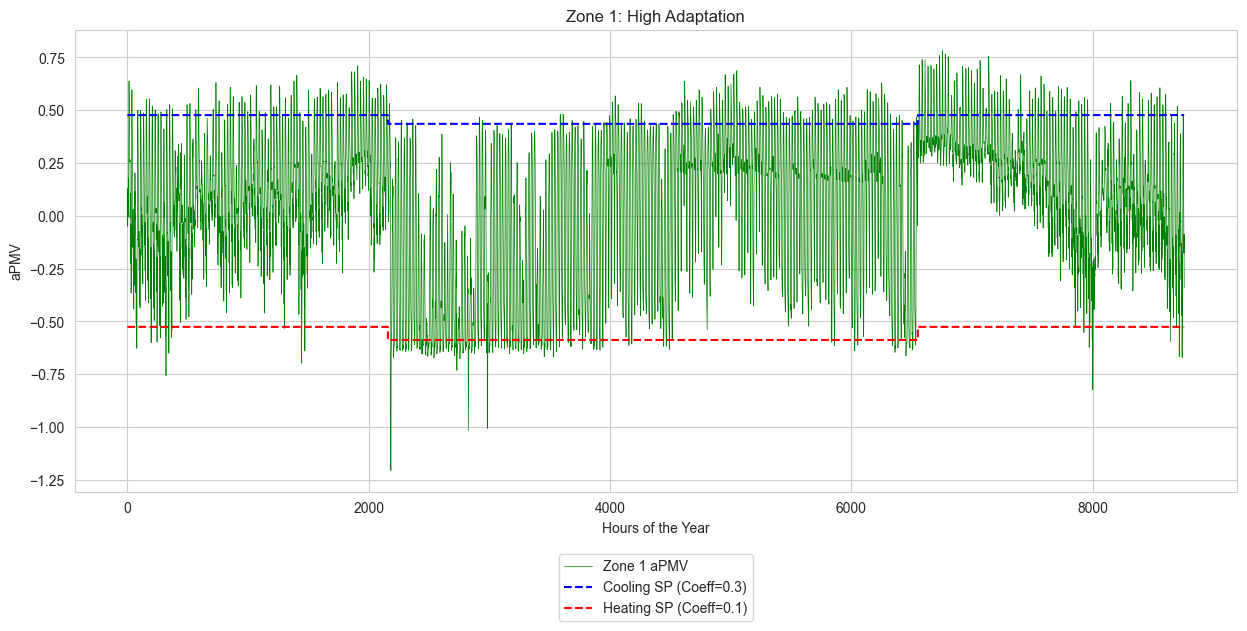

In [19]:
# Get columns for Zone 1
z1_apmv, z1_cool, z1_heat = get_columns(df_apmv, 'Block1_Zone1')

plt.figure()
sns.lineplot(data=df_apmv, x='Hour', y=z1_apmv, color='green', linewidth=0.5, label='Zone 1 aPMV')
sns.lineplot(data=df_apmv, x='Hour', y=z1_cool, color='blue', linewidth=1.5, linestyle='--', label='Cooling SP (Coeff=0.3)')
sns.lineplot(data=df_apmv, x='Hour', y=z1_heat, color='red', linewidth=1.5, linestyle='--', label='Heating SP (Coeff=0.1)')

plt.title('Zone 1: High Adaptation')
plt.ylabel('aPMV')
plt.xlabel('Hours of the Year')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), frameon=True)
plt.show()

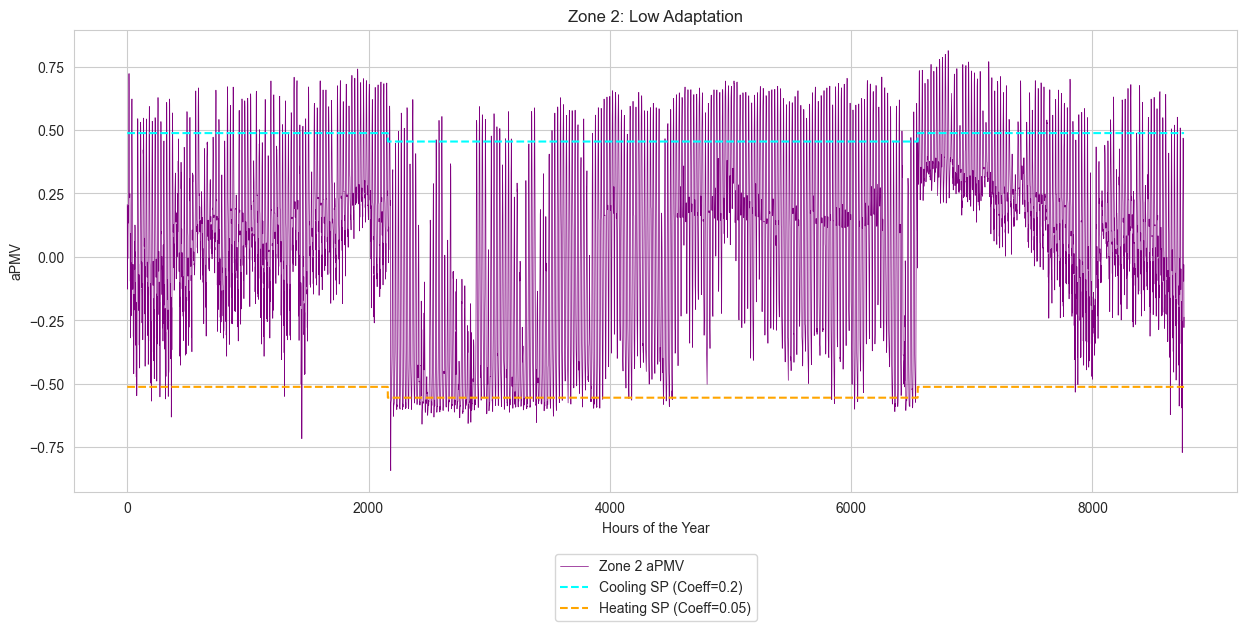

In [20]:
# Get columns for Zone 2
z2_apmv, z2_cool, z2_heat = get_columns(df_apmv, 'Block1_Zone2')

plt.figure()
sns.lineplot(data=df_apmv, x='Hour', y=z2_apmv, color='purple', linewidth=0.5, label='Zone 2 aPMV')
sns.lineplot(data=df_apmv, x='Hour', y=z2_cool, color='cyan', linewidth=1.5, linestyle='--', label='Cooling SP (Coeff=0.2)')
sns.lineplot(data=df_apmv, x='Hour', y=z2_heat, color='orange', linewidth=1.5, linestyle='--', label='Heating SP (Coeff=0.05)')

plt.title('Zone 2: Low Adaptation')
plt.ylabel('aPMV')
plt.xlabel('Hours of the Year')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), frameon=True)

plt.show()

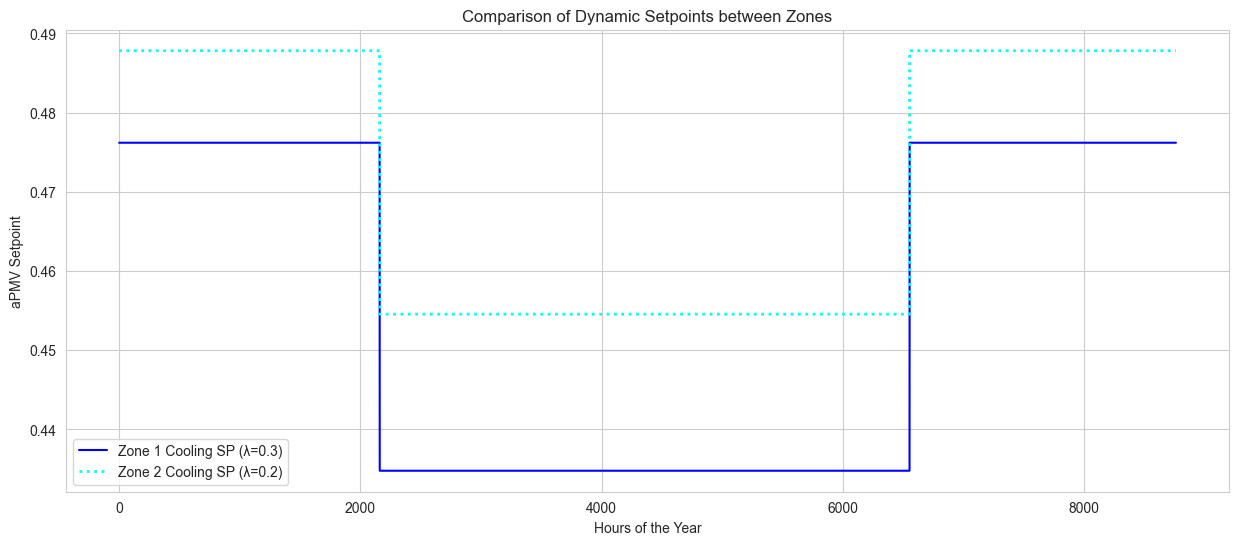

In [21]:
# Compare cooling setpoints to see the impact of the lambda coefficient
plt.figure()
sns.lineplot(data=df_apmv, x='Hour', y=z1_cool, color='blue', label='Zone 1 Cooling SP (λ=0.3)')
sns.lineplot(data=df_apmv, x='Hour', y=z2_cool, color='cyan', linestyle=':', linewidth=2, label='Zone 2 Cooling SP (λ=0.2)')

plt.title('Comparison of Dynamic Setpoints between Zones')
plt.ylabel('aPMV Setpoint')
plt.xlabel('Hours of the Year')
plt.legend()
plt.show()

## Cleanup

This final section removes the generated simulation directories to keep the workspace clean. **Warning:** This will permanently delete the simulation results.

In [22]:
import shutil

# List of output directories defined previously
output_dirs = ['sim_results_pmv', 'sim_results_apmv']

print("Starting cleanup...")

for folder in output_dirs:
    if os.path.exists(folder):
        try:
            shutil.rmtree(folder)
            print(f"✅ Deleted directory: {folder}")
        except Exception as e:
            print(f"❌ Error deleting {folder}: {e}")
    else:
        print(f"⚠️ Directory not found (already deleted or not created): {folder}")

print("Cleanup finished.")

Starting cleanup...
✅ Deleted directory: sim_results_pmv
✅ Deleted directory: sim_results_apmv
Cleanup finished.
